In [1]:
## Import Packages
import numpy as np
import _pickle as pk
import Area_Avg as aa
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=40,**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

In [2]:
sw = pk.load(open(\
    'Data/CanESM5_p2/Custom/Fluxes/CanESM5_p2_Custom_TrCLsw_FB_MZdecomp_Grid.pi','rb'))
lw = pk.load(open(\
    'Data/CanESM5_p2/Custom/Fluxes/CanESM5_p2_Custom_TrCLlw_FB_MZdecomp_Grid.pi','rb'))

p2_sw = pk.load(open(\
    'Data/CanESM5_p2/Fluxes/CanESM5_p2_TrCLsw_FLUX_FB_MZdecomp_Grid.pi','rb'))
    
p2_lw = pk.load(open(\
    'Data/CanESM5_p2/Fluxes/CanESM5_p2_TrCLlw_FLUX_FB_MZdecomp_Grid.pi','rb'))

lat = np.linspace(-87.864,87.864,64)
lon = np.linspace(0,357.1875,128)

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat,(lon.size,1)).T

In [3]:
sw_g = dict()
lw_g = dict()

p2_sw_g = dict()
p2_lw_g = dict()

sw_plot = dict()
lw_plot = dict()

p2_sw_plot = dict()
p2_lw_plot = dict()
for prop in sw.keys():
    sw_g[prop] = dict()
    lw_g[prop] = dict()
    p2_sw_g[prop] = dict()
    p2_lw_g[prop] = dict()
    
    sw_plot[prop] = dict()
    lw_plot[prop] = dict()
    p2_sw_plot[prop] = dict()
    p2_lw_plot[prop] = dict()
    for exp in sw[prop].keys():
        sw_g[prop][exp] = dict()
        lw_g[prop][exp] = dict()
        
        sw_plot[prop][exp] = dict()
        lw_plot[prop][exp] = dict()
        p2_sw_plot[prop][exp] = dict()
        p2_lw_plot[prop][exp] = dict()
        for hgt in sw[prop][exp].keys():
            sw_g[prop][exp][hgt] = np.average(np.mean(sw[prop][exp][hgt],axis=0),weights=coslat)
            lw_g[prop][exp][hgt] = np.average(np.mean(lw[prop][exp][hgt],axis=0),weights=coslat)
            
            sw_plot[prop][exp][hgt] = np.nanmean(np.concatenate((\
            sw[prop][exp][hgt][:,:,64:],sw[prop][exp][hgt][:,:,0:64]),axis=2),axis=0)
            sw_plot[prop][exp][hgt],lon_cyc = add_cyclic_point(sw_plot[prop][exp][hgt],lon)
            
            p2_sw_g[prop][hgt] = np.average(p2_sw[prop][hgt],weights=coslat)
            p2_lw_g[prop][hgt] = np.average(p2_lw[prop][hgt],weights=coslat)

print('Comparing Feedback Strength using different methods')
for prop in sw_g.keys():
    print('\n',prop)
    for hgt in sw_g[prop]['5SST'].keys():
        print('\n',hgt)
        print('\nSW Regression - ',p2_sw_g[prop][hgt])
        print('SW Difference - ',sw_g[prop]['5SST'][hgt])
        print('\nLW Regression - ',p2_lw_g[prop][hgt])
        print('LW Difference - ',lw_g[prop]['5SST'][hgt])

diff_stack_sw1 = dict()
diff_stack_lw1 = dict()

reg_stack_sw1 = dict()
reg_stack_lw1 = dict()

for prop in sw_g.keys():
    diff_stack_sw1[prop] = np.stack(list(sw_g[prop]['5SST'].values()),axis=0)
    diff_stack_lw1[prop] = np.stack(list(lw_g[prop]['5SST'].values()),axis=0)
    
    reg_stack_sw1[prop] = np.stack(list(p2_sw_g[prop].values()),axis=0)
    reg_stack_lw1[prop] = np.stack(list(p2_lw_g[prop].values()),axis=0)
    
diff_stk_sw = np.stack(list(diff_stack_sw1.values()),axis=0).reshape(18)
diff_stk_lw = np.stack(list(diff_stack_lw1.values()),axis=0).reshape(18)

reg_stk_sw = np.stack(list(reg_stack_sw1.values()),axis=0).reshape(18)
reg_stk_lw = np.stack(list(reg_stack_lw1.values()),axis=0).reshape(18)

plt.figure(figsize=(12,6),dpi=300)
plt.suptitle('Decomposed Cloud Feedback Method Comparison')

plt.subplot(121)
plt.title('CanESM5-p2 Shortwave')
plt.scatter(diff_stk_sw,reg_stk_sw)
plt.xlabel('Finite Difference (30 year means)')
plt.ylabel('Regression (150 years)')
plt.ylim(-0.8,0.8)
plt.xlim(-0.8,0.8)
plt.plot(np.linspace(-1,1,18),np.linspace(-1,1,18),color='k',linestyle=':')

plt.subplot(122)
plt.title('CanESM5-p2 Longwave')
plt.xlabel('Finite Difference (30 year means)')
plt.ylabel('Regression (150 years)')
plt.scatter(diff_stk_lw,reg_stk_lw)
plt.plot(np.linspace(-1,1,18),np.linspace(-1,1,18),color='k',linestyle=':')
plt.ylim(-0.8,0.8)
plt.xlim(-0.8,0.8)

#plt.savefig('CLD_FB_Methods_Comp.png',bbox_inches='tight')

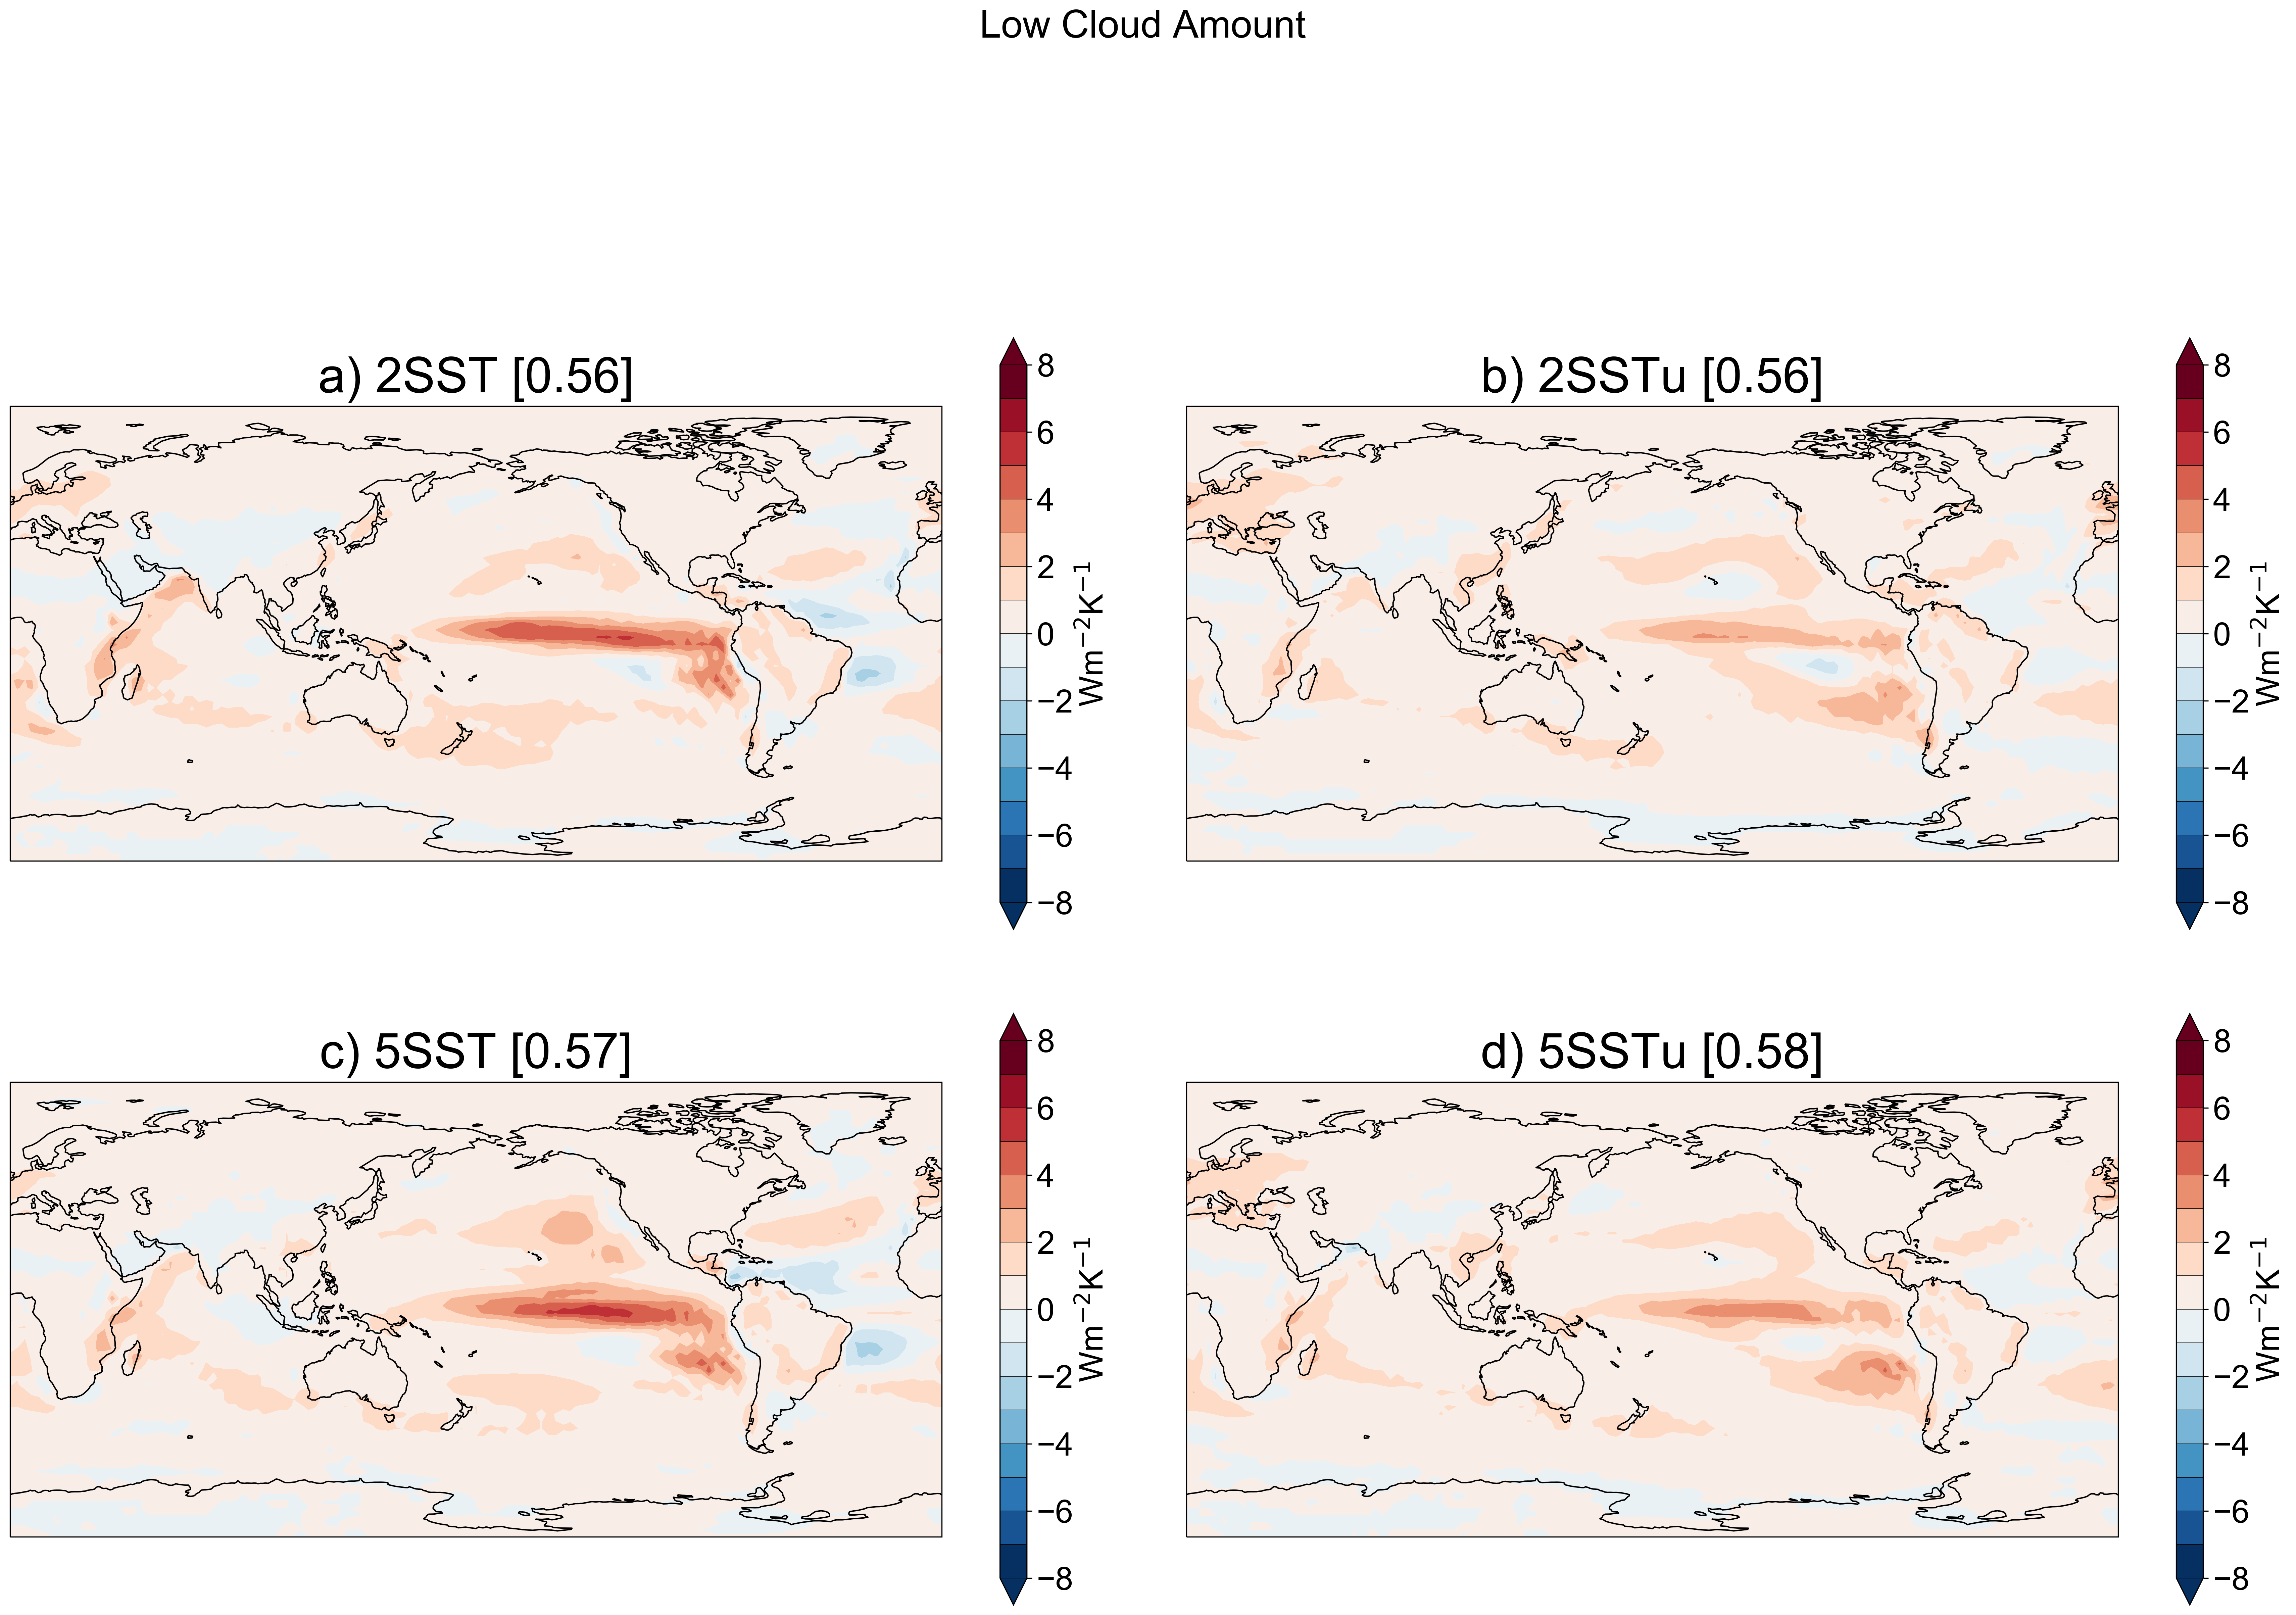

In [7]:
mpl.rc('font',size=23,**{'family':'sans-serif','sans-serif':['Arial']})
bounds = np.arange(-8,8.1,1)
bounds_ticks = np.arange(-8,8.1,2)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(30,20),dpi=300)
plt.suptitle('Low Cloud Amount')
#gs = gridspec.GridSpec(3,2, width_ratios=[0.6,1],height_ratios=[1,1,1]) 

#CanESM2------------------
ax = plt.subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('a) 2SST [{}]'.format(round(sw_g['Amount']['2SST']['Low'],2)),\
             fontsize=35,pad=10)
im = ax.contourf(lon_cyc,lat,sw_plot['Amount']['2SST']['Low'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax.coastlines()
plt.colorbar(im,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)
#plt.text(0.15,1.3,'SW High Cloud Amount',fontsize=40,transform = ax.transAxes)

ax1 = plt.subplot(222,projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_title('b) 2SSTu [{}]'.format(round(sw_g['Amount']['2SSTu']['Low'],2)),\
             fontsize=35,pad=10)
im1 = ax1.contourf(lon_cyc,lat,sw_plot['Amount']['2SSTu']['Low'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()
plt.colorbar(im1,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)
#plt.text(0.2,1.3,'SW Low Cloud Amount',fontsize=40,transform = ax1.transAxes)

########

ax4 = plt.subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
ax4.set_title('c) 5SST [{}]'.format(round(sw_g['Amount']['5SST']['Low'],2)),\
             fontsize=35,pad=10)
im4 = ax4.contourf(lon_cyc,lat,sw_plot['Amount']['5SST']['Low'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax4.coastlines()
plt.colorbar(im4,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)

ax5 = plt.subplot(224,projection=ccrs.PlateCarree(central_longitude=180))
ax5.set_title('d) 5SSTu [{}]'.format(round(sw_g['Amount']['5SSTu']['Low'],2)),\
             fontsize=35,pad=10)
im5 = ax5.contourf(lon_cyc,lat,sw_plot['Amount']['5SSTu']['Low'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax5.coastlines()
plt.colorbar(im5,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)

plt.subplots_adjust(wspace=0.01, hspace=-0.2)

#plt.savefig('CLD_LowAmtHiOpt_FB_Map.eps',bbox_inches='tight')

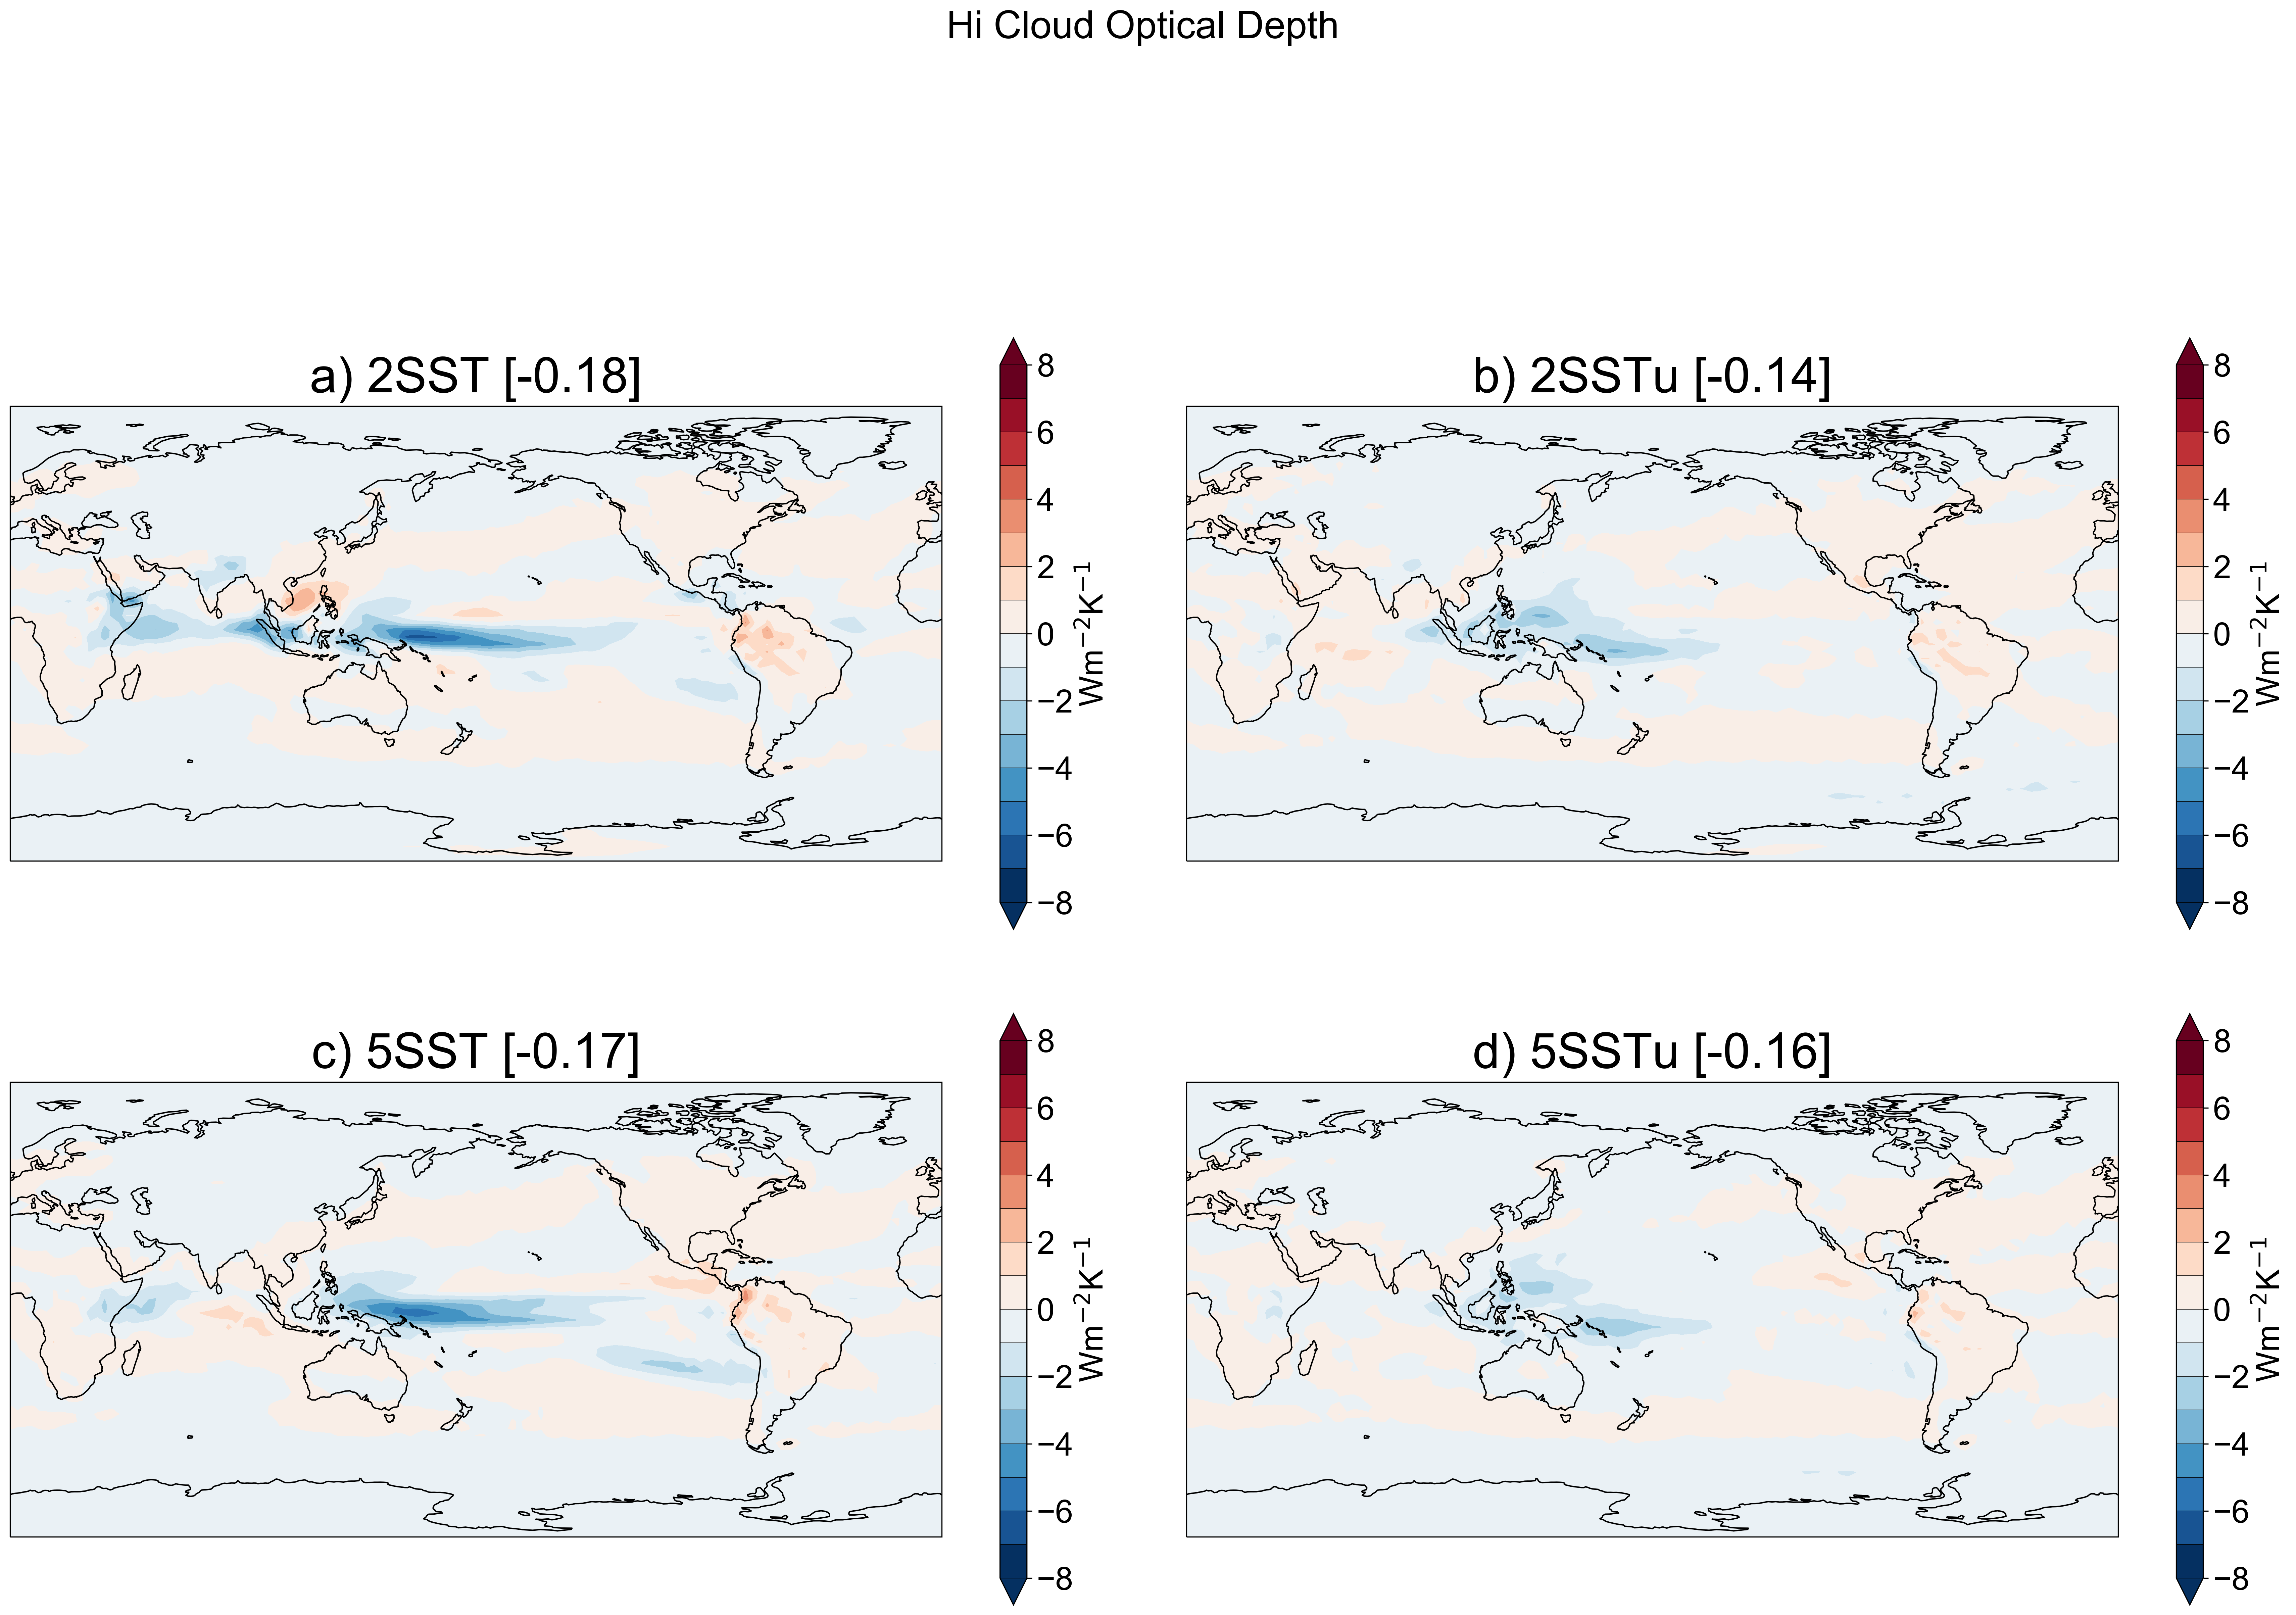

In [6]:
mpl.rc('font',size=23,**{'family':'sans-serif','sans-serif':['Arial']})
bounds = np.arange(-8,8.1,1)
bounds_ticks = np.arange(-8,8.1,2)
cmap = plt.cm.RdBu_r
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(30,20),dpi=300)
plt.suptitle('Hi Cloud Optical Depth')
#gs = gridspec.GridSpec(3,2, width_ratios=[0.6,1],height_ratios=[1,1,1]) 

#CanESM2------------------
ax = plt.subplot(221,projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('a) 2SST [{}]'.format(round(sw_g['Optical Depth']['2SST']['Hi'],2)),\
             fontsize=35,pad=10)
im = ax.contourf(lon_cyc,lat,sw_plot['Optical Depth']['2SST']['Hi'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax.coastlines()
plt.colorbar(im,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)
#plt.text(0.15,1.3,'SW High Cloud Optical Depth',fontsize=40,transform = ax.transAxes)

ax1 = plt.subplot(222,projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_title('b) 2SSTu [{}]'.format(round(sw_g['Optical Depth']['2SSTu']['Hi'],2)),\
             fontsize=35,pad=10)
im1 = ax1.contourf(lon_cyc,lat,sw_plot['Optical Depth']['2SSTu']['Hi'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax1.coastlines()
plt.colorbar(im1,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)
#plt.text(0.2,1.3,'SW Hi Cloud Optical Depth',fontsize=40,transform = ax1.transAxes)

########

ax4 = plt.subplot(223,projection=ccrs.PlateCarree(central_longitude=180))
ax4.set_title('c) 5SST [{}]'.format(round(sw_g['Optical Depth']['5SST']['Hi'],2)),\
             fontsize=35,pad=10)
im4 = ax4.contourf(lon_cyc,lat,sw_plot['Optical Depth']['5SST']['Hi'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax4.coastlines()
plt.colorbar(im4,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)

ax5 = plt.subplot(224,projection=ccrs.PlateCarree(central_longitude=180))
ax5.set_title('d) 5SSTu [{}]'.format(round(sw_g['Optical Depth']['5SSTu']['Hi'],2)),\
             fontsize=35,pad=10)
im5 = ax5.contourf(lon_cyc,lat,sw_plot['Optical Depth']['5SSTu']['Hi'],\
                   bounds,cmap=cmap,norm=norm,extend='both')
ax5.coastlines()
plt.colorbar(im5,ticks=bounds_ticks,drawedges=True,label='Wm$^{-2}$K$^{-1}$',shrink=0.7)

plt.subplots_adjust(wspace=0.01, hspace=-0.2)

#plt.savefig('CLD_HiAmtHiOpt_FB_Map.eps',bbox_inches='tight')